In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"uswashariq","key":"0a4766a1cb2cff7a9edcd43c4024088a"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle

In [3]:
!kaggle datasets download -d mmuzamil/real-and-fake-currency-pakistanis-dataset -p data_pkr

Dataset URL: https://www.kaggle.com/datasets/mmuzamil/real-and-fake-currency-pakistanis-dataset
License(s): unknown
100% 1.14G/1.15G [00:05<00:00, 285MB/s]
100% 1.15G/1.15G [00:05<00:00, 213MB/s]


In [4]:
!unzip -q data_pkr/real-and-fake-currency-pakistanis-dataset.zip -d data_pkr

In [5]:
# 1) See what type of file it is
!file "data_pkr/Real And  Fake Currency Dataset"

# 2) Try to unzip it into a new folder "inner"
!mkdir -p data_pkr/inner
!unzip -q "data_pkr/Real And  Fake Currency Dataset" -d data_pkr/inner || echo "unzip failed"

# 3) Show all folders up to depth 3 so we can see where things are
!find data_pkr -maxdepth 3 -type d -print

data_pkr/Real And  Fake Currency Dataset: Zip archive data, at least v1.0 to extract, compression method=store
data_pkr
data_pkr/inner
data_pkr/inner/Fake Notes
data_pkr/inner/Real Notes


In [6]:
# Create final folders
!mkdir -p data_pkr/real data_pkr/fake

# Move real images
!mv "data_pkr/inner/Real Notes"/* data_pkr/real/

# Move fake images
!mv "data_pkr/inner/Fake Notes"/* data_pkr/fake/

# Verify
print("Real images:", len(list(__import__("os").listdir("data_pkr/real"))))
print("Fake images:", len(list(__import__("os").listdir("data_pkr/fake"))))

!ls data_pkr/real | head
!ls data_pkr/fake | head

Real images: 950
Fake images: 650
Real-Notes (100).jpg
Real-Notes (101).jpg
Real-Notes (102).jpg
Real-Notes (103).jpg
Real-Notes (104).jpg
Real-Notes (105).jpg
Real-Notes (106).jpg
Real-Notes (107).jpg
Real-Notes (108).jpg
Real-Notes (109).jpg
fakes-Notes (100).jpg
fakes-Notes (101).jpg
fakes-Notes (102).jpg
fakes-Notes (103).jpg
fakes-Notes (104).jpg
fakes-Notes (105).jpg
fakes-Notes (106).jpg
fakes-Notes (107).jpg
fakes-Notes (108).jpg
fakes-Notes (109).jpg


In [7]:
import os
import shutil

root = "data_pkr"

# Make class folders if not exist
os.makedirs(f"{root}/real", exist_ok=True)
os.makedirs(f"{root}/fake", exist_ok=True)

# Move images into the right folders
for f in os.listdir(root):
    path = os.path.join(root, f)

    if os.path.isfile(path):
        fname = f.lower()

        if "real" in fname:
            shutil.move(path, f"{root}/real/{f}")
        elif "fake" in fname or "fakes" in fname:
            shutil.move(path, f"{root}/fake/{f}")


In [8]:
!ls data_pkr/real | head
!ls data_pkr/fake | head

Real And  Fake Currency Dataset
real-and-fake-currency-pakistanis-dataset.zip
Real-Notes (100).jpg
Real-Notes (101).jpg
Real-Notes (102).jpg
Real-Notes (103).jpg
Real-Notes (104).jpg
Real-Notes (105).jpg
Real-Notes (106).jpg
Real-Notes (107).jpg
fakes-Notes (100).jpg
fakes-Notes (101).jpg
fakes-Notes (102).jpg
fakes-Notes (103).jpg
fakes-Notes (104).jpg
fakes-Notes (105).jpg
fakes-Notes (106).jpg
fakes-Notes (107).jpg
fakes-Notes (108).jpg
fakes-Notes (109).jpg


In [9]:
!rm -rf data_pkr/inner
!ls data_pkr

fake  real


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [12]:
DATA_DIR = "data_pkr"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

In [13]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)


In [14]:
train_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

Found 1280 images belonging to 2 classes.


In [15]:
val_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False    # keep order fixed for evaluation
)


Found 320 images belonging to 2 classes.


In [16]:
print("Class indices:", train_gen.class_indices)

Class indices: {'fake': 0, 'real': 1}


In [17]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')   # 0 = fake, 1 = real
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 260s 6s/step - accuracy: 0.5764 - loss: 0.9808 - val_accuracy: 0.7688 - val_loss: 0.4904
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 272s 7s/step - accuracy: 0.7112 - loss: 0.5892 - val_accuracy: 0.8062 - val_loss: 0.4223
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 270s 7s/step - accuracy: 0.8085 - loss: 0.4437 - val_accuracy: 0.8344 - val_loss: 0.4057
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 247s 6s/step - accuracy: 0.7888 - loss: 0.4531 - val_accuracy: 0.8188 - val_loss: 0.4411
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 234s 6s/step - accuracy: 0.8384 - loss: 0.3915 - val_accuracy: 0.8094 - val_loss: 0.4162
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 234s 6s/step - accuracy: 0.8466 - loss: 0.3705 - val_accuracy: 0.8188 - val_loss: 0.4200
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 240s 6s/step - accuracy: 0.8451 - loss: 0.3427 - val_accuracy: 0.8313 - val_loss: 0.4278
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 233s 6s/step - accuracy: 0.8662 - loss: 0.3132 - val_accuracy: 0.8125 - v

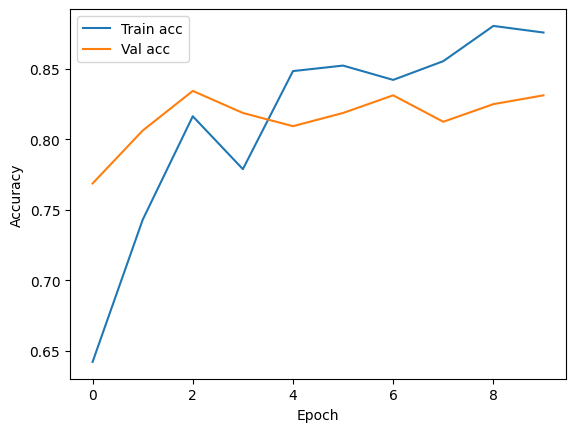

In [21]:
# Accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

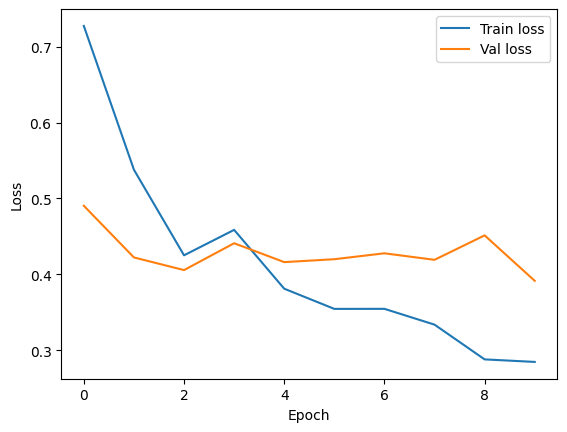

In [22]:
# Loss
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
# Save the trained model
model.save("currency_cnn_pkr.h5")
print("Model saved as currency_cnn_pkr.h5")

Model saved as currency_cnn_pkr.h5


In [24]:
# Predictions on validation set
val_gen.reset()
y_pred_prob = model.predict(val_gen)
y_pred = (y_pred_prob.ravel() >= 0.5).astype(int)

10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step


In [25]:
y_true = val_gen.classes
target_names = list(val_gen.class_indices.keys())

In [26]:
print("Class mapping:", val_gen.class_indices)
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=target_names))

Class mapping: {'fake': 0, 'real': 1}

Classification Report:

              precision    recall  f1-score   support

        fake       0.82      0.79      0.80       130
        real       0.86      0.88      0.87       190

    accuracy                           0.84       320
   macro avg       0.84      0.84      0.84       320
weighted avg       0.84      0.84      0.84       320



In [27]:
model.save("currency_model.h5")

In [28]:
!pip install gradio

In [29]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import gradio as gr

In [30]:
model = load_model("currency_model.h5")

In [31]:
IMG_SIZE = (224, 224)

def predict_currency(img):
    # Resize to training size
    img = img.resize(IMG_SIZE)

    # Convert to array and scale
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prob = model.predict(img_array)[0][0]   # scalar between 0 and 1

    if prob >= 0.5:
        label = "Real Currency Note"
        confidence = prob
    else:
        label = "Fake Currency Note"
        confidence = 1 - prob

    # 👉 Return TWO values: (label, confidence%)
    return label, round(float(confidence) * 100, 2)

In [32]:
demo = gr.Interface(
    fn=predict_currency,
    inputs=gr.Image(type="pil", label="Upload PKR currency note"),
    outputs=[
        gr.Textbox(label="Prediction"),
        gr.Number(label="Confidence (%)")
    ],
    title="Pakistani Currency Real/Fake Detector",
    description="Upload an image of a Pakistani currency note to check whether it is real or fake."
)

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://96f01583100907f328.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


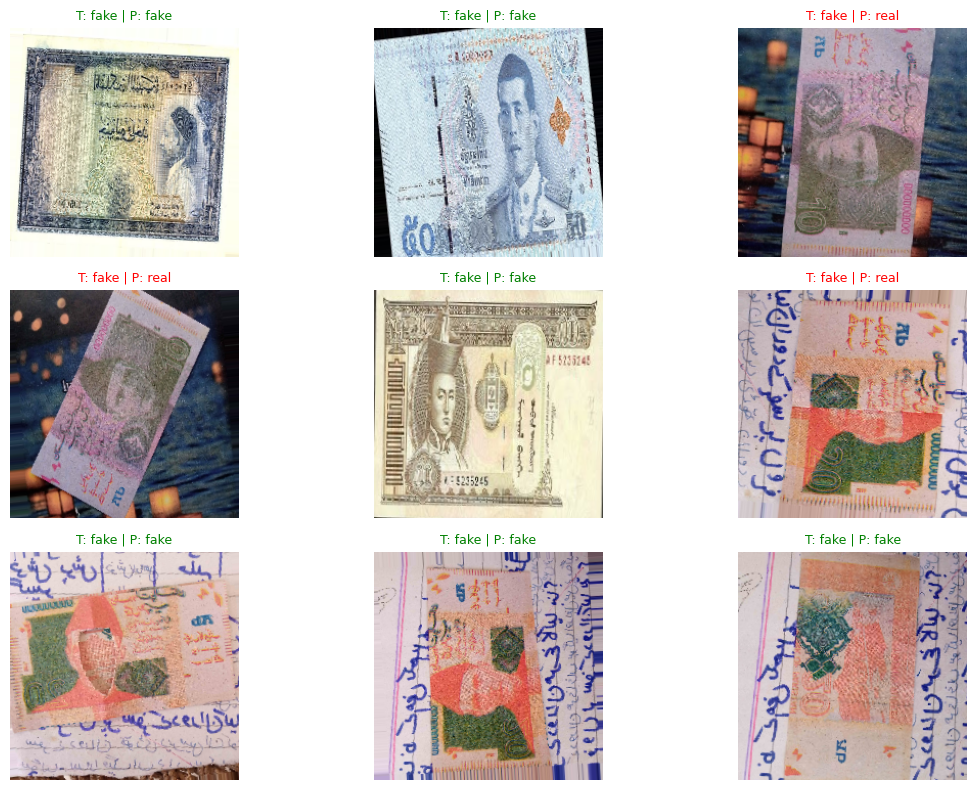

In [33]:
import matplotlib.pyplot as plt
import numpy as np

class_names = ['fake', 'real']  # 0 -> fake, 1 -> real

# get one batch from validation generator
images, labels = next(val_gen)   # val_gen you already created

# model predictions
pred_probs = model.predict(images)
pred_labels = (pred_probs.ravel() >= 0.5).astype(int)

plt.figure(figsize=(12, 8))
for i in range(9):  # show 9 images
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    true_label = class_names[int(labels[i])]
    pred_label = class_names[int(pred_labels[i])]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"T: {true_label} | P: {pred_label}", color=color, fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [34]:
# after training
model.save("currency_model.h5")
!ls -lh currency_model.h5

-rw-r--r-- 1 root root 43M Dec  1 08:48 currency_model.h5
